In [122]:
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Rescaling, Normalization, BatchNormalization, Dropout
from keras.regularizers import l2
import tensorflow as tf; tf.config.set_visible_devices([], 'GPU')

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = Rescaling(scale=1.0 / 255.0)(X_train)
X_test = Rescaling(scale=1.0 / 255.0)(X_test)

print(X_train.shape, X_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


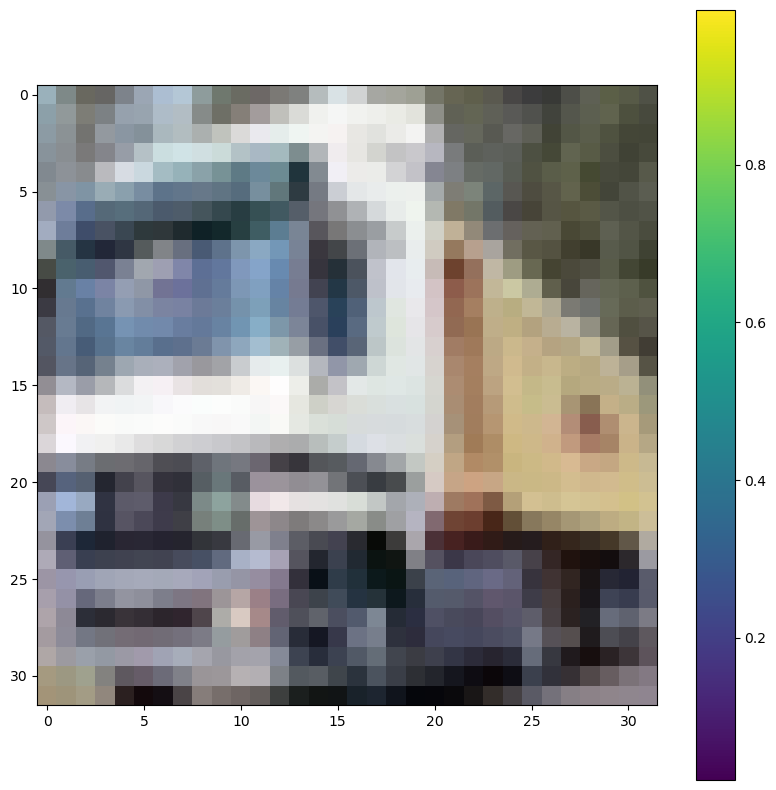

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(X_train[1])
plt.colorbar()
plt.show()

# Build CNN

In [124]:
model = Sequential()

model.add(Input(shape=(32, 32, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='valid', kernel_regularizer=l2(0.0005)))
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(96, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(10, activation='softmax'))

# Complie model

In [125]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model : Copy LeNet-5 Algorithm

In [126]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

# set the learning rate schedule as created in the original paper
def lr_schedule(epoch):
    if epoch <= 2:     
        lr = 5e-4
    elif epoch > 2 and epoch <= 5:
        lr = 2e-4
    elif epoch > 5 and epoch <= 9:
        lr = 5e-5
    else: 
        lr = 1e-5
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# set the checkpointer
checkpointer = ModelCheckpoint(filepath='CIFAR10.best.weights.keras', verbose=1, 
                               save_best_only=True)

# train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_split=0.5, callbacks=[checkpointer, lr_scheduler], 
          verbose=2, shuffle=True)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.82627, saving model to CIFAR10.best.weights.keras
782/782 - 14s - loss: 2.1329 - accuracy: 0.2444 - val_loss: 1.8263 - val_accuracy: 0.3694 - lr: 5.0000e-04 - 14s/epoch - 18ms/step
Epoch 2/20

Epoch 2: val_loss improved from 1.82627 to 1.63213, saving model to CIFAR10.best.weights.keras
782/782 - 14s - loss: 1.7469 - accuracy: 0.3900 - val_loss: 1.6321 - val_accuracy: 0.4429 - lr: 5.0000e-04 - 14s/epoch - 18ms/step
Epoch 3/20

Epoch 3: val_loss did not improve from 1.63213
782/782 - 14s - loss: 1.5462 - accuracy: 0.4813 - val_loss: 2.3314 - val_accuracy: 0.3448 - lr: 5.0000e-04 - 14s/epoch - 18ms/step
Epoch 4/20

Epoch 4: val_loss improved from 1.63213 to 1.24627, saving model to CIFAR10.best.weights.keras
782/782 - 14s - loss: 1.3567 - accuracy: 0.5628 - val_loss: 1.2463 - val_accuracy: 0.5925 - lr: 2.0000e-04 - 14s/epoch - 18ms/step
Epoch 5/20

Epoch 5: val_loss improved from 1.24627 to 1.16699, saving model to CIFAR10.best.weights

#Load the Model with the Best Classification Accuracy on the Validation Set

In [132]:
# load the weights that yielded the best validation accuracy
model.load_weights('CIFAR10.best.weights.keras')

# Plot the graph

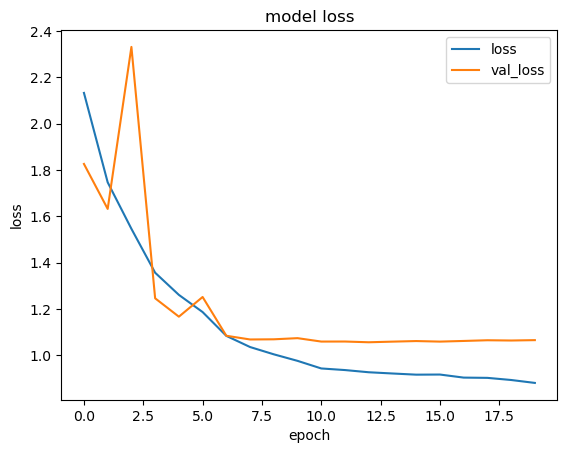

In [127]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

# Confirm model

313/313 [==============================] - 2s 7ms/step
Predicted Answer: 3
Answer: [3]


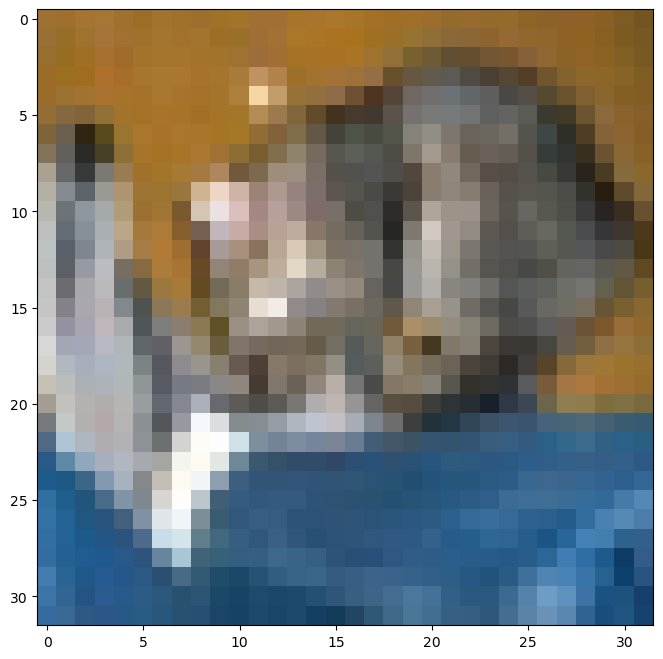

In [133]:
y_pred = model.predict(X_test)
print(f'Predicted Answer: {y_pred[0].argmax()}')
print(f'Answer: {y_test[0]}')

plt.figure(figsize=(8, 8))
plt.imshow(X_test[0])
plt.show()

# Test real image

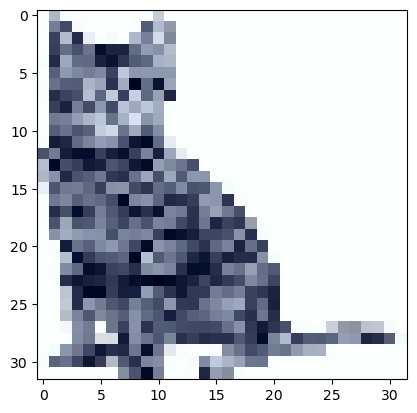

In [134]:
import cv2 as cv
import numpy as np

# Normalization 레이어를 사용하여 이미지 정규화
normalizer = Normalization()

# 학습 데이터를 사용하여 Normalization 레이어를 맞춤
normalizer.adapt(X_train)

def preprocess_image(image_path):
    img = cv.imread(image_path)
    img = cv.resize(img, (32, 32))
    
    rescaler = Rescaling(scale=1.0 / 255.0)
    img = rescaler(img)
    
    img = normalizer(img)
    
    img = img.numpy().reshape(1,32,32,3)
    
    return img

image = preprocess_image('cat.jpg')

# 이미지를 [0, 1] 범위로 조정하여 표시
display_image = (image - np.min(image)) / (np.max(image) - np.min(image))

# 이미지 표시
plt.imshow(display_image.reshape(32, 32, 3))
plt.show()

## Normalization 레이어의 adapt 메서드
    - 주어진 데이터셋의 평균과 표준편차를 계산하여 레이어가 이 통계에 맞춰 작동하도록 함.

In [135]:
@tf.function
def predict_image(model, image):
    return model(image)

pred = predict_image(model, image)
print(f"Predicted probability: {pred}")
print(f'predicted number = {pred.numpy().argmax()}')

Predicted probability: [[0.0058561  0.00102028 0.0851317  0.29813737 0.0354293  0.44827914
  0.01136934 0.11086176 0.0006388  0.00327638]]
predicted number = 5
